# Reconocimiento de rostros utilizando máquinas de vectores de soporte y análisis en componentes principales.

En esta libreta vamos a hacer el clásico algoritmo conocido como *eigenfaces* con el fin de ilustrar el uso de las máquinas de vector de soporte y los componentes principales. Para darle más énfasis a esto, no vamos a utilizar los métodos de análisis y optimización que ya existen en Scikit learn.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from gzip import GzipFile  #  Para abrir el archivo comprimido

## 1.  Carga imágenes y nombres a partir de los archivos

Para este problema, se utilizaron ejemplos del conjunto de imagenes
[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz), 
el cual tiene un tamaño de 233MB.

Los datos preprocesados se obtuvieron de la librería de bases de datos de
prueba de [scikit.learn](http://sourceforge.net/projects/scikit-learn/files/data/), 
pero los presentamos en esta libreta por separado, con el fn de mostrar un poco el proceso
completo paso a paso.
  
Para preprocesar las imagenes, se utilizó [openCV](http://opencv.willowgarage.com/wiki/Welcome).
En cada imagen:

1. Se utilizó *OpenCV* para localizar y extraer el rostro

2. Se recortó y escaló a una resolución de 64x64 pixeles

3. Se convirtió a escala de grises

4. Se transformó a un arreglo tipo *numpy*

5. Se coloco una imagen sobre otra 

6. Se guardo como un archivo de numpy (usando np.save)

7. Se comprimió el archivo usando el método gzip (sin comprimir son 250 Mb).

El archivo es ``faces.npy.gz``

Los nombres de las imágenes (donde se puede extraer el nombre
de la persona que aparece) se guardó en el archivo texto ``face_filenames.txt``


In [2]:
caras = np.load(GzipFile("faces.npy.gz"))

nombre_caras = [l.strip().rsplit('_',1)[0]
                for l in open("face_filenames.txt").readlines()]


# A cada cara se le quita el brillo restandole el
# valor medio de brillo de cada una.
caras = caras - caras.mean(axis=1).reshape(caras.shape[0],1)

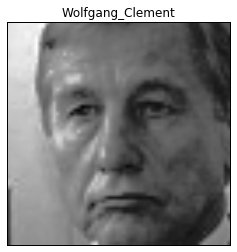

In [3]:
# Ejemplo para ver las imagenes

ej = np.random.randint(caras.shape[0])
imagen_ejemplo = np.reshape(caras[ej,:].copy(), (64,64))
plt.imshow(imagen_ejemplo, cmap=plt.cm.gray)
plt.title(nombre_caras[ej])
plt.xticks(())
plt.yticks(())
plt.show()

## 2. Acondicionamiento de los datos de objetivos T 


Una vez que se tiene bien establecido el objetivo, entonces
hay que generar el vector Y de salidas o *targets*.

Para esto vamos a utilizar varias operaciones de ``numpy`` que
no habíamos utilizado antes.

- ``np.unique(A)`` devuelve un vector con los valores diferentes de A.

- ``np.searchsorted(A, V)`` regresa un vector de indices donde se encuentra cada elemento de A en V.

- ``np.bincount(X)`` cuenta el número de ocurrencias 

- ``np.in1d(A,B)`` encuentra los indices donde en A hay un elemento que se encuentra en B. Lo devuelve como
  False o True, por lo que se puede utilizar a lo largo de los renglones sin problemas.

Como se tienen demasiadas clases (una por cada nombre), lo
que vamos a hacer es reducir la complejidad del problema a
solamente clasificar los 5 rostros mas repetidos en los datos.
Así tenemos que encontrar las 5 clases con mayor frecuencia en
los datos y a partir de ahi obtener las matrices X y T para
aprendizaje.


In [4]:
# Genera el vector de targets
nombre_caras_array = np.array(nombre_caras)
caras_diferentes = np.unique(nombre_caras_array)
Y_completa = np.searchsorted(caras_diferentes, nombre_caras_array)

# Encuentra las clases (en números enteros) más repetidas en T
clases_retenidas = np.argsort(np.bincount(Y_completa))[-5:]


# Obtiene indices y extrae la nueva matriz
indices = np.in1d(Y_completa, clases_retenidas)
X = caras[indices]
Y = Y_completa[indices]
Y = Y.reshape(-1, 1) # Vector columna

# Revuelve en forma aleatoria los datos
indices = range(Y.shape[0])
np.random.shuffle(indices)
X = X[indices,:]
Y = Y[indices,:]

# Separa el 25% de los datos como datos de prueba
separa = 3 * Y.shape[0] / 4
X_e, X_t = X[:separa,:], X[separa:,:]
Y_e, Y_t = Y[:separa,:], Y[separa:,:]


# Imprime la información sobre los datos retenidos
# para aprendizaje y prueba 

print "Las caras que se repitan mas son: \n"
print caras_diferentes[clases_retenidas]
print "\nTamano del conjunto de aprendizaje:\n"
print "Numero de atributos: ", X_e.shape[1]
print "Numero de elementos para aprendizaje: ", X_e.shape[0]
print "Numero de elementos para prueba: ", X_t.shape[0]

Las caras que se repitan mas son: 

['Gerhard_Schroeder' 'Donald_Rumsfeld' 'Tony_Blair' 'Colin_Powell'
 'George_W_Bush']

Tamano del conjunto de aprendizaje:

Numero de atributos:  4096
Numero de elementos para aprendizaje:  845
Numero de elementos para prueba:  282


## 3.  Preprocesamiento de datos de entrada

Si tomamos tal cual la información para clasificación,
entonces tenemos 64 $\times$ 64 atributos (1024), de los cuales
muchos son redundantes.

Para reconocimiento de rostros se utiliza muy normalmente
una técnica conocida como *eigenfaces*, la cual no es más
que aplicar una transformación lineal conocida como **Análisis
en componentes principales** a la información que se obtiene
en un vector que representa pixeles.

El análisis en componentes principales (PCA), asume que los datos
de aprendizaje son significativos estadísticamente, por lo que
se le aplica una matriz de rotación a los datos con el fin de
buscar un cambio de coordenandas, en las cuales las covarianzas
entre cualquier par de dimensiones diferentes sea 0. 

Para realizar el PCA hay que realizar una operación muy macabrona del
análisis numérico: la obtención de valores propios y vectores propios.
En general los algoritmos eficientes (numéricamente) solo funcionan
para matrices densas y pequeñas o para matrices muy grandes y dispersas.

``Scikit.learn`` provee tres métodos de PCA, donde solo varía la manera
en que obtiene los valores propios y vectores propios. Para no fallar,
utilizaremos ``RandomizedPCA`` que funciona tanto para matrices pequeñas y densas
como dispersas, pero que es menos eficiente que los otros dos métodos que son
especializados para cada caso.

Es importante recordar que la extracción de características y
normalización siempre se realiza asumiendo que los únicos datos
conocidos son los de aprendizaje, y luego se transforman los datos
de prueba a partir de los datos establecidos.

In [5]:
# Aqui se encuentra el método de componentes principales
from sklearn.decomposition import RandomizedPCA

# Número de componentes principales retenidas
componentes_principales = 150

# Genera un objeto pca con n_components componentes principales retenidas.
# whiten=True implica un escalamiento de las componentes para asegurar
# que sean completamente ortogonales entre ellas, aunque se pierde la posibilidad
# de obtener de nuevo los valores originales a partir de las componentes principales.
pca = RandomizedPCA(n_components=componentes_principales, whiten=True)

# Ajusta las componentes con los datos de aprendizaje
pca.fit(X_e)

# Obtiene los datos en PCA para usar tanto para aprendizaje como prueba
X_e_pca = pca.transform(X_e)
X_t_pca = pca.transform(X_t)

¿Fácil, verdad? Ahora veamos que se obtuvo de esto. Recuerda que el número de componentes requeridos lo puedes variar (mientras menos componentes, menos información pero ménos parámetros necesarios en el aprendizaje, unas por otras).


Tamaño del conjunto de aprendizaje preprocesado:

Atributos:  150 	 Elementos:  845


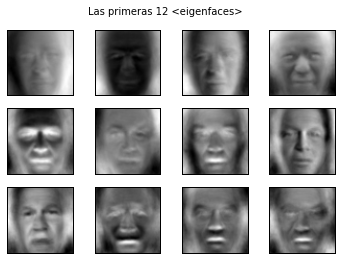

In [6]:
# Imprime la información sobre los datos preprocesados
# así como la imagen de la <<eigenface>> o máscara que
# permite encontrar los componentes más determinantes
# para encontrar diferencias entre los datos. 

print "\nTamaño del conjunto de aprendizaje preprocesado:\n"
print "Atributos: ", X_e_pca.shape[1], "\t Elementos: ", X_e_pca.shape[0]

# Se obtienen las "Caras genéricas (una por componente principal)"
# solo para ver las caras más genérica por curiosidad
eigenfaces = pca.components_.reshape((componentes_principales, 64, 64))

columnas, renglones = 4, 3
for i in range(columnas * renglones):
    plt.subplot(renglones, columnas, i + 1)
    plt.imshow(eigenfaces[i,:,:].copy().squeeze(), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Las primeras 12 <eigenfaces>")
plt.show()

## 4. Clasificación utilizando una Máquina de vectores de soporte lineal

Vamos ahora a utilizar la máquina de vectores de soporte sin el truco del kernel, o lo que es lo mismo, con un kernel lineal. Para esto vamos a utilizar la máquina de vector de soporte que viene incluida en la librería de ``scikit-learn``. Es de tener en cuenta que para los clasificadores que solo usan Kernel lineal existe su propia función, la cual se encuentra optimizada, a diferencia que la función que utiliza el truco del kernel, la cual no se puede optimizar (en velocidad de ejecución tanto). 

In [7]:
# Esta es la clase de clasificadores tipo SVM con kernel lineal
from sklearn.svm import LinearSVC

# Ahora vamos a obtener las funciones para evaluar un clasificador
from sklearn.metrics import accuracy_score

No es la mejor forma de ajustar un clasificador (y definitivamente no la vamos
a usar mas adelante así), pero vamos a ajustar los valores del clasificador a mano.

Esto es, vamos a utilizar los datos de entrenamiento para aprender, los de prueba para estimarlos, y 
vamos a revisar con la función ``classification_report`` los indicadores básicos de un clasificador,
por clase y globales.

Esto implica que entonces vamos a manosear bastante los datos de prueba, por lo que serán en este caso, datos de
validación más que de prueba.

In [8]:
# Genera el objeto clasificador SVM lineal
C = 1.0
clasificador = LinearSVC(C=C)

# Entrenamiento
clasificador.fit(X_e_pca, Y_e.squeeze())

#Predicción
Y_estimada = clasificador.predict(X_t_pca)

print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

El porcentaje de acierto, con C =  1.0  es de  0.836879432624


### Ejercicio 1. Analizando los PCA y el SVM lineal

Responde a las siguientes preguntas. Para hacerlo utiliza las celdas siguientes. Una para poder realizar pruebas en python y corroborar las ideas que se quieran plasmar, y el otro donde se responde a cada una de las preguntas.

**Preguntas**

1. Ajusta el valor de C para obtener el mayor valor del porcentaje de acierto. ¿Cuál es el valor de C?
   ¿Cual es el mejor porcentaje de acierto?

2. ¿Se obtienen los mismos resultados si se ejecuta la libreta completa varias veces? ¿Porqué?

3. ¿Que pasa con el error de clasificación si en lugar de usar las *eigenfaces* se utilizan los datos originales?

4. ¿Que pasa si se usan solo 50 componentes principales? ¿Que pasa si se utilizan 500?



# Pregunta 1 
1)
Pues para determinar el valor de C una persona en un foro de research gate dice que 
"A good way to estimate the better C to be used is to perform a grid search before the final training." el link del post es [este](https://www.researchgate.net/post/In_support_vector_machinesSVM_how_we_adjust_the_parameter_C_why_we_use_this_parameter)  revisando el metodo en scikit-learn la verdad no le entendi .. pero de todas formas me lo piratie y medio lo adapte vamos a ver que tal jala este es el [link](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)  

In [9]:
from sklearn import svm, grid_search

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clasificador = grid_search.GridSearchCV(svr, parameters)
clasificador.fit(X_e_pca, Y_e.squeeze())

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

El mejor valor que encontro fue con C = 1 como se ve arriba vamos a ejecutar la linea de prediccion el valor de C que se muestra es del ejercicio anterior pero en los resultados presentados con el GridSearch se ve que tambien es C = 1 

In [10]:
Y_estimada = clasificador.predict(X_t_pca)
print "El porcentaje de acierto, con C = ", C, " es de ",
print accuracy_score(Y_t.squeeze(), Y_estimada)

El porcentaje de acierto, con C =  1.0  es de  0.829787234043


Pues el valor esta bastante cerca del 83% pero es el mismo valor de C como dije antes porque pasa el valor de C antes definido.. pero bueno igual aun no se utilizar esta herramienta entonces mejor voy hacerlo jugando con los valores de C primero buscando los valores de C de 1 a 100 y claro sus porcentajes de acierto.

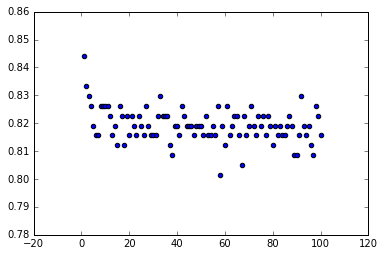

In [11]:
valores_c = np.arange(1, 101)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal
    C = x
    clasificador = LinearSVC(C=C)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

Claramente se ve que mientras mas pequenio sea el valor de C mejor porcentaje de acierto se tiene vamos a ver cual fue el mejor valor

In [12]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice]

El mejor porcentaje de acierto lo tuvo C =  1 con  0.843971631206


El menor valor fue 1 lo curioso aqui es que ya habiamos calculado el valor en el cual obtuvimos 0.836879432624 y ahora 0.843971631206 .. en fin vamos a probar ahora con los valores de 0.01 a 1 a ver que pasa ..

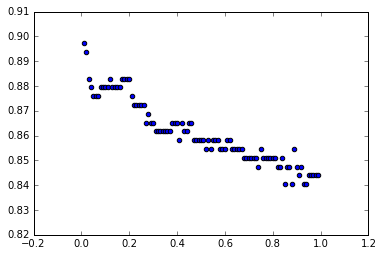

In [13]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal
    C = x
    clasificador = LinearSVC(C=C)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [14]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice]

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.897163120567


Pues se ve un comportamiento ascendente de 1 a 0 al parecer mientras mas pequenio sea C mejor porcentaje de acierto se tiene ya que de 0.84 subio a 0.89 el porcentaje de acierto.

# Pregunta 2 
2)
Pues hubo cambios entre el ejemplo con C = 1 y el experimento que realize tambien con C = 1 para ver si hay cambios se volvera a correr el experimento para ver si se obtiene la misma C o el mismo porcentaje de acierto.

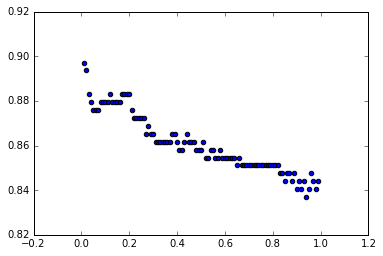

In [15]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal
    C = x
    clasificador = LinearSVC(C=C)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [16]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice]

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.897163120567


En el primer experimento de 0.01 a 1 se obtuvo el mejor porcentaje de acierto con el valor de 0.897163120567 y con una C =  0.01. En este nuevo experimento se obtuvo exactamente lo mismo .. Pues en este caso no pero en el pasado vimos que vario en ambos experimentos con C = 1

# Pregunta 3 
3)
Vamos a probar el mismo experimento pero ahora con los datos originales osea sin la transformacion.

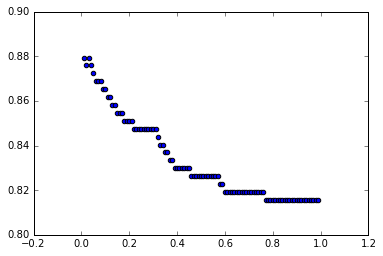

In [17]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal
    C = x
    clasificador = LinearSVC(C=C)

    # Entrenamiento
    clasificador.fit(X_e, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [18]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice]

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.879432624113


De entrada tarda mucho mas tiempo .. en cuanto a los valores de porcentaje de acierto con las eigenfaces se obtuvo 
0.897163120567 y con los datos originales 0.879432624113 ambos porcentajes con la misma C. al parecer con los datos originales aumenta el error de clasificacion.

# Pregunta 4 
4) 
Primero con 50 componentes de entrada vamos a reciclar la porcion de codigo

In [19]:
# Aqui se encuentra el método de componentes principales
from sklearn.decomposition import RandomizedPCA

# Número de componentes principales retenidas
componentes_principales = 50

# Genera un objeto pca con n_components componentes principales retenidas.
# whiten=True implica un escalamiento de las componentes para asegurar
# que sean completamente ortogonales entre ellas, aunque se pierde la posibilidad
# de obtener de nuevo los valores originales a partir de las componentes principales.
pca = RandomizedPCA(n_components=componentes_principales, whiten=True)

# Ajusta las componentes con los datos de aprendizaje
pca.fit(X_e)

# Obtiene los datos en PCA para usar tanto para aprendizaje como prueba
X_e_pca = pca.transform(X_e)
X_t_pca = pca.transform(X_t)

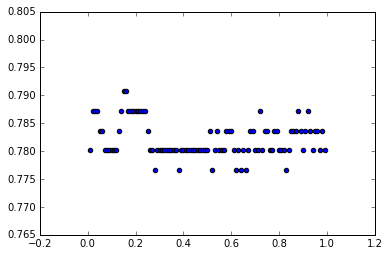

In [20]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal
    C = x
    clasificador = LinearSVC(C=C)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [21]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice]

El mejor porcentaje de acierto lo tuvo C =  0.15 con  0.790780141844


Pues con los componentes_principales = 50 cambio mucho la grafica de los datos ahora se obtuvo una C =  0.15 con porcentaje de acierto de 0.790780141844 lo cual el valor es menor al 80% del que ya estabamos acostumbrados ahora vamos sobre los 500

In [22]:
# Aqui se encuentra el método de componentes principales
from sklearn.decomposition import RandomizedPCA

# Número de componentes principales retenidas
componentes_principales = 500

# Genera un objeto pca con n_components componentes principales retenidas.
# whiten=True implica un escalamiento de las componentes para asegurar
# que sean completamente ortogonales entre ellas, aunque se pierde la posibilidad
# de obtener de nuevo los valores originales a partir de las componentes principales.
pca = RandomizedPCA(n_components=componentes_principales, whiten=True)

# Ajusta las componentes con los datos de aprendizaje
pca.fit(X_e)

# Obtiene los datos en PCA para usar tanto para aprendizaje como prueba
X_e_pca = pca.transform(X_e)
X_t_pca = pca.transform(X_t)

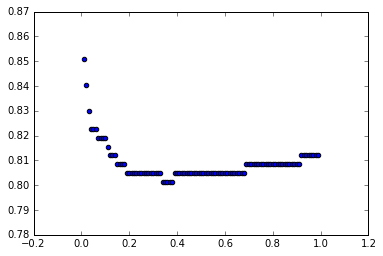

In [23]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal
    C = x
    clasificador = LinearSVC(C=C)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [24]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice]

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.851063829787


Ahora obtuvimos que el mejor valor de C = 0.01 el cual ya habia salido en los resultados de la pregunta 1, 2 y 3. 
Las diferencias son que en lugar de mejorar empeoro como se ve en los siguientes valores


* 0.897163120567 (Pregunta 1)
* 0.897163120567 (Pregunta 2)
* 0.879432624113 (Pregunta 3)
* 0.851063829787 (Pregunta 4)

Ademas del tiempo en que tardo en arrojar los resultados ..

### Ejercicio 2. Analizando el uso de SVM con diferentes kernels

Responde a las siguientes preguntas. Para hacerlo utiliza las celdas siguientes. Una para poder realizar pruebas en python y corroborar las ideas que se quieran plasmar, y el otro donde se responde a cada una de las preguntas.

**Preguntas**

1. Utiliza una SVM con kernel polinomial. Ajusta los valores de $C$ y el grado del polinomio para aumentar el porcentaje de acierto en los datos de validaciñon. ¿Cuales son los valores de $C$ y el grado del polinomio con mejores resultados?

2. Utiliza una SVM con kernel gaussiano. Ajusta los valores de $C$ y $\gamma$ para aumentar el porcentaje de acierto en los datos de validaciñon. ¿Cuales son los valores de $C$ y $\gamma$ con mejores resultados?

3. ¿Cual Kernel prefieres? ¿Porqué?

4. ¿Que pasa con el error de clasificación si en lugar de usar las *eigenfaces* se utilizan los datos originales?

5. ¿Que pasa si se usan solo 50 componentes principales? ¿Que pasa si se utilizan 500?

6. ¿Porque crees que es bueno usar las eigenfaces?



# Pregunta 1 
1)
Pues de entrada se aplicara la misma idea en cuanto a los valores de C de 0.01 a 1 en cuanto al grado en la libreta de regularizacion se usaron los grados 2, 4, 6 y 8 los cuales tambien se utilizaran aqui solo que antes volveremos a poner los numeros de componentes a 150.

In [25]:
from sklearn.svm import SVC 

In [26]:
# Aqui se encuentra el método de componentes principales
from sklearn.decomposition import RandomizedPCA

# Número de componentes principales retenidas
componentes_principales = 150

# Genera un objeto pca con n_components componentes principales retenidas.
# whiten=True implica un escalamiento de las componentes para asegurar
# que sean completamente ortogonales entre ellas, aunque se pierde la posibilidad
# de obtener de nuevo los valores originales a partir de las componentes principales.
pca = RandomizedPCA(n_components=componentes_principales, whiten=True)

# Ajusta las componentes con los datos de aprendizaje
pca.fit(X_e)

# Obtiene los datos en PCA para usar tanto para aprendizaje como prueba
X_e_pca = pca.transform(X_e)
X_t_pca = pca.transform(X_t)

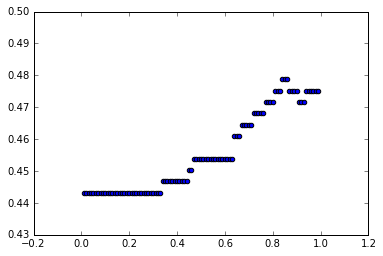

In [27]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(kernel="poly", C=x, degree=2)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [28]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y de grado 2."

El mejor porcentaje de acierto lo tuvo C =  0.84 con  0.478723404255 y de grado 2.


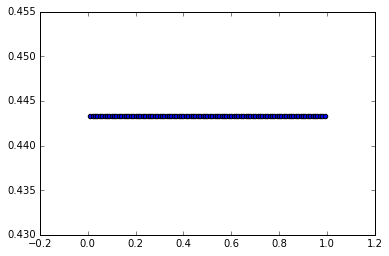

In [29]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(kernel="poly", C=x, degree=4)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [30]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y de grado 4."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 4.


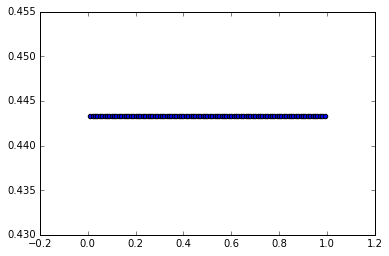

In [31]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(kernel="poly", C=x, degree=6)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [32]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y de grado 6."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 6.


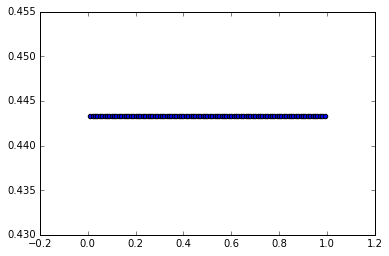

In [33]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(kernel="poly", C=x, degree=8)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [34]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y de grado 8."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 8.


Los resultados obtenidos fueron los siguientes:

* El mejor porcentaje de acierto lo tuvo C =  0.84 con  0.478723404255 y de grado 2.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 4.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 6.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 8.

Pues el mejor resultado fue con C= 0.84 con porcentaje de acierto de 0.478723404255 y de grado 2.
Lo curioso aqui que al aumentar el grado las graficas se hicieron constantes..

# Pregunta 2 
2)
Pues de entrada se aplicara la misma idea en cuanto a los valores de C de 0.01 a 1 en cuanto al valor de gamma se usara 2, 4, 6 y 8.

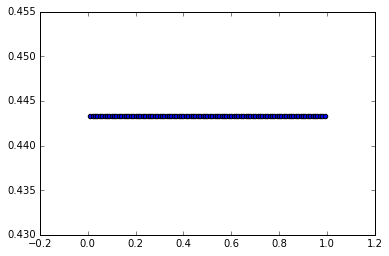

In [35]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(gamma=2, C=x)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [36]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y con gamma igual a 2."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 2.


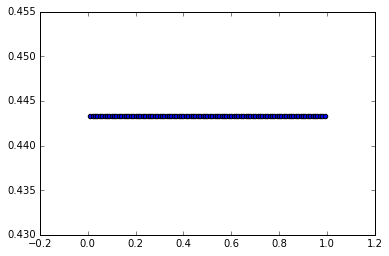

In [37]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(gamma=4, C=x)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [38]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y con gamma igual a 4."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 4.


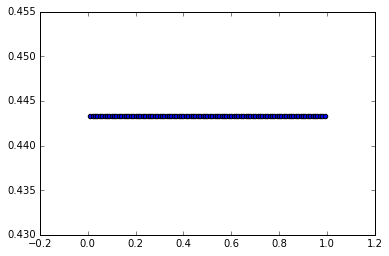

In [39]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(gamma=6, C=x)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [40]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y con gamma igual a 6."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 6.


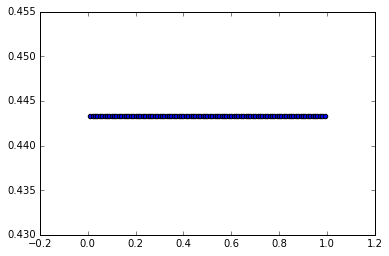

In [41]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(gamma=8, C=x)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [42]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y con gamma igual a 8."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 8.


Los resultados obtenidos fueron:

* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 2.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 4.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 6.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 8.

Pues no hay variabilidad en los resultados se obtiene la misma C y el mismo porcentaje de acierto al variar la gamma.

# Pregunta 3
3)
Pues viendo los resultados es facil de decidir que un kernel polinomial de grado 2 en este caso ya que 
fue el que mejor porcentaje de acierto tuvo con 0.478723404255 lo interesante aqui es que los demas experimentos llegaron al mismo porcentaje de acierto de 0.443262411348

# Pregunta 4
4)
De entrada esperando a que terminare de ejecutarse esto pasaron 2 3 horas por lo que solo se hara el primer caso con un kernel polinomial de grado 2 y el otro con un kernel gaussiano con gamma igual a 2 y se compararan los experimentos con los ya realizados.

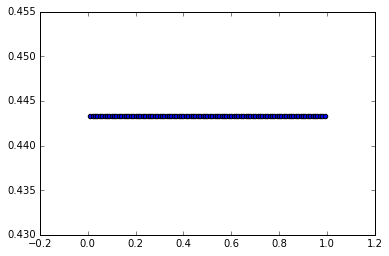

In [43]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(kernel="poly", C=x, degree=2)

    # Entrenamiento
    clasificador.fit(X_e, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [44]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y de grado 2."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 2.


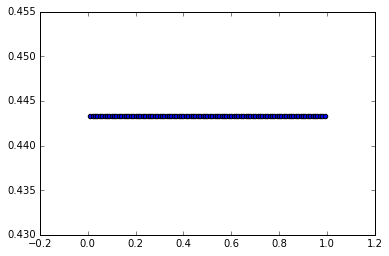

In [45]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(gamma=2, C=x)

    # Entrenamiento
    clasificador.fit(X_e, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [46]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y con gamma igual a 2."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 2.


Como ya se menciono fueron algo mas tardado estos experimentos pero la diferencia de hacerlo con los datos originales en contra de con los eigenfaces son los siguientes:

Eigenfaces

* El mejor porcentaje de acierto lo tuvo C =  0.84 con  0.478723404255 y de grado 2.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 2.

Datos originales

* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y de grado 2.
* El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 2.

Casi todos llegaron al mismo porcentaje de acierto de 0.443262411348 a excepcion del primero en cuanto al error de clasificacion parece que aumenta claro si consideramos solamente el primer experimento en el otro caso es el mismo.

# Pregunta 5
5) Primero vamos a ver con 50

In [47]:
# Aqui se encuentra el método de componentes principales
from sklearn.decomposition import RandomizedPCA

# Número de componentes principales retenidas
componentes_principales = 50

# Genera un objeto pca con n_components componentes principales retenidas.
# whiten=True implica un escalamiento de las componentes para asegurar
# que sean completamente ortogonales entre ellas, aunque se pierde la posibilidad
# de obtener de nuevo los valores originales a partir de las componentes principales.
pca = RandomizedPCA(n_components=componentes_principales, whiten=True)

# Ajusta las componentes con los datos de aprendizaje
pca.fit(X_e)

# Obtiene los datos en PCA para usar tanto para aprendizaje como prueba
X_e_pca = pca.transform(X_e)
X_t_pca = pca.transform(X_t)

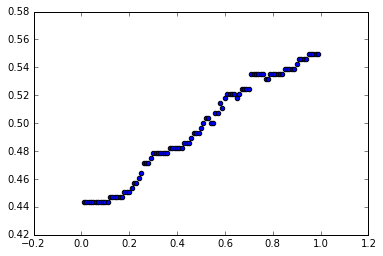

In [48]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(kernel="poly", C=x, degree=2)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [49]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y de grado 2."

El mejor porcentaje de acierto lo tuvo C =  0.95 con  0.549645390071 y de grado 2.


De entrada la grafica vario bastante de ser una constante ahora se ve mucha mas variabilidad ademas de aumentar el porcentaje de acierto el cual habia sido el mejor con 0.478723404255 ahora paso a ser reemplazado con 0.549645390071. Ahora vamos con 500

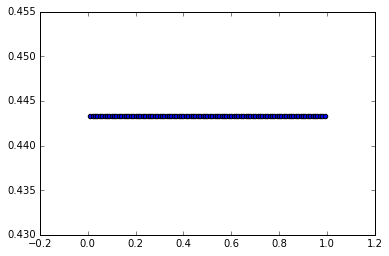

In [50]:
valores_c = np.arange(0.01, 1, 0.01)
valores = []
for x in valores_c:
    # Genera el objeto clasificador SVM lineal

    clasificador = SVC(gamma=2, C=x)

    # Entrenamiento
    clasificador.fit(X_e_pca, Y_e.squeeze())

    #Predicción
    Y_estimada = clasificador.predict(X_t_pca)

    valores.append(accuracy_score(Y_t.squeeze(), Y_estimada))

plt.scatter(valores_c, valores)
plt.show()

In [51]:
valores = np.asarray(valores)
indice = np.argmax(valores)
print "El mejor porcentaje de acierto lo tuvo C = ", valores_c[indice], "con ", valores[indice], "y con gamma igual a 2."

El mejor porcentaje de acierto lo tuvo C =  0.01 con  0.443262411348 y con gamma igual a 2.


En este caso no hubo cambios se obtuvo la misma C =  0.01 y porcentaje de acierto de 0.443262411348.

# Pregunta 6
6) Porque se obtienen resultados mucho mas rapido a comparacion de con los datos originales.